NOTE: Copy of `dataset_eda.ipynb` notebook adjusted for seasonality hierarchy.

In [17]:
import sys
sys.path.append('..')

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import dvc.api
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

from messis.dataloader import GeospatialDataModule


params = dvc.api.params_show()

In [19]:
N_FOLDS = params['number_of_folds']

In [20]:
folds = []
for i in range(N_FOLDS):
    val_fold = (i + 1) % N_FOLDS

    data_module = GeospatialDataModule(data_dir='../data/',
                                       train_folds=list(set(range(N_FOLDS)) - {i, val_fold}),
                                       val_folds=[val_fold],
                                       test_folds=[i],
                                       batch_size=12,
                                       num_workers=1,
                                       debug=True,
                                       subsets=None)

    data_module.setup()
    folds.append(data_module.test_dataset)

Setting up GeospatialDataModule for stage: None. Data augmentation config: {}
Loading mean/std stats from ../data/chips_stats.yaml
Stats with selected test fold 2: {'mean': [586.2720336914062, 705.8182373046875, 461.1337585449219, 3173.60107421875, 2013.3826904296875, 1214.2362060546875], 'n_chips': 70, 'std': [478.10137939453125, 361.135986328125, 307.4477233886719, 1095.1683349609375, 726.4973754882812, 645.2523803710938]} over 3 timesteps.
Stats with selected test fold 3: {'mean': [597.5504150390625, 715.9369506835938, 466.4729309082031, 3200.169921875, 2026.0472412109375, 1226.4827880859375], 'n_chips': 70, 'std': [478.5570983886719, 355.21527099609375, 302.90582275390625, 1075.492431640625, 719.2570190429688, 643.1681518554688]} over 3 timesteps.
Stats with selected test fold 4: {'mean': [603.1135864257812, 720.5563354492188, 467.7790222167969, 3286.48388671875, 2076.3505859375, 1256.5230712890625], 'n_chips': 70, 'std': [471.8617858886719, 350.39794921875, 302.1551208496094, 989.

In [21]:
pixels_by_tier_category_fold = [] # list for each fold: dict with tier as key: dict with category as key: pixel count as value
for i in range(N_FOLDS):
    print(f"Processing fold {i}")
    pixels_by_tier_category = {
        "tier1": {},
        "tier2": {},
        # "tier3": {}
    }
    for batch in tqdm(folds[i]):
        targets = batch[1][0]
        for j, tier in enumerate(pixels_by_tier_category.keys()):
            # get the unique values and their counts
            unique, counts = targets[j].unique(return_counts=True)
            # create a dictionary with the unique values and their counts
            for clazz, count in zip(unique, counts):
                if clazz.item() in pixels_by_tier_category[tier]:
                    pixels_by_tier_category[tier][clazz.item()] += count.item()
                else:
                    pixels_by_tier_category[tier][clazz.item()] = count.item()
            #unique_counts = {int(clazz): int(count) for clazz, count in zip(unique, counts)}
            #print(unique_counts)
            
            # add the counts to the corresponding tier
    pixels_by_tier_category_fold.append(pixels_by_tier_category)

Processing fold 0


100%|██████████| 71/71 [00:01<00:00, 40.71it/s]


Processing fold 1


100%|██████████| 71/71 [00:01<00:00, 44.42it/s]


Processing fold 2


100%|██████████| 70/70 [00:01<00:00, 46.31it/s]


Processing fold 3


100%|██████████| 70/70 [00:01<00:00, 42.24it/s]


Processing fold 4


100%|██████████| 70/70 [00:01<00:00, 42.94it/s]


Processing fold 5


100%|██████████| 70/70 [00:01<00:00, 44.34it/s]


In [22]:
print(f"len(pixels_by_tier_category_fold): {len(pixels_by_tier_category_fold)}")
print(f"len(pixels_by_tier_category_fold[0]): {len(pixels_by_tier_category_fold[0])}")
print(f"len(pixels_by_tier_category_fold[0]['tier1']): {len(pixels_by_tier_category_fold[0]['tier1'])}")
print(f"pixels_by_tier_category_fold[0]['tier1']: {pixels_by_tier_category_fold[0]['tier1']}")

len(pixels_by_tier_category_fold): 6
len(pixels_by_tier_category_fold[0]): 2
len(pixels_by_tier_category_fold[0]['tier1']): 4
pixels_by_tier_category_fold[0]['tier1']: {0: 2863559, 1: 124369, 2: 297712, 3: 276856}


In [23]:
import json
dataset_info = json.load(open('../data/dataset_info.json'))

dataset_info["tier1"]

['Background', 'AnnualCrop', 'PerennialCrop', 'Permaculture']

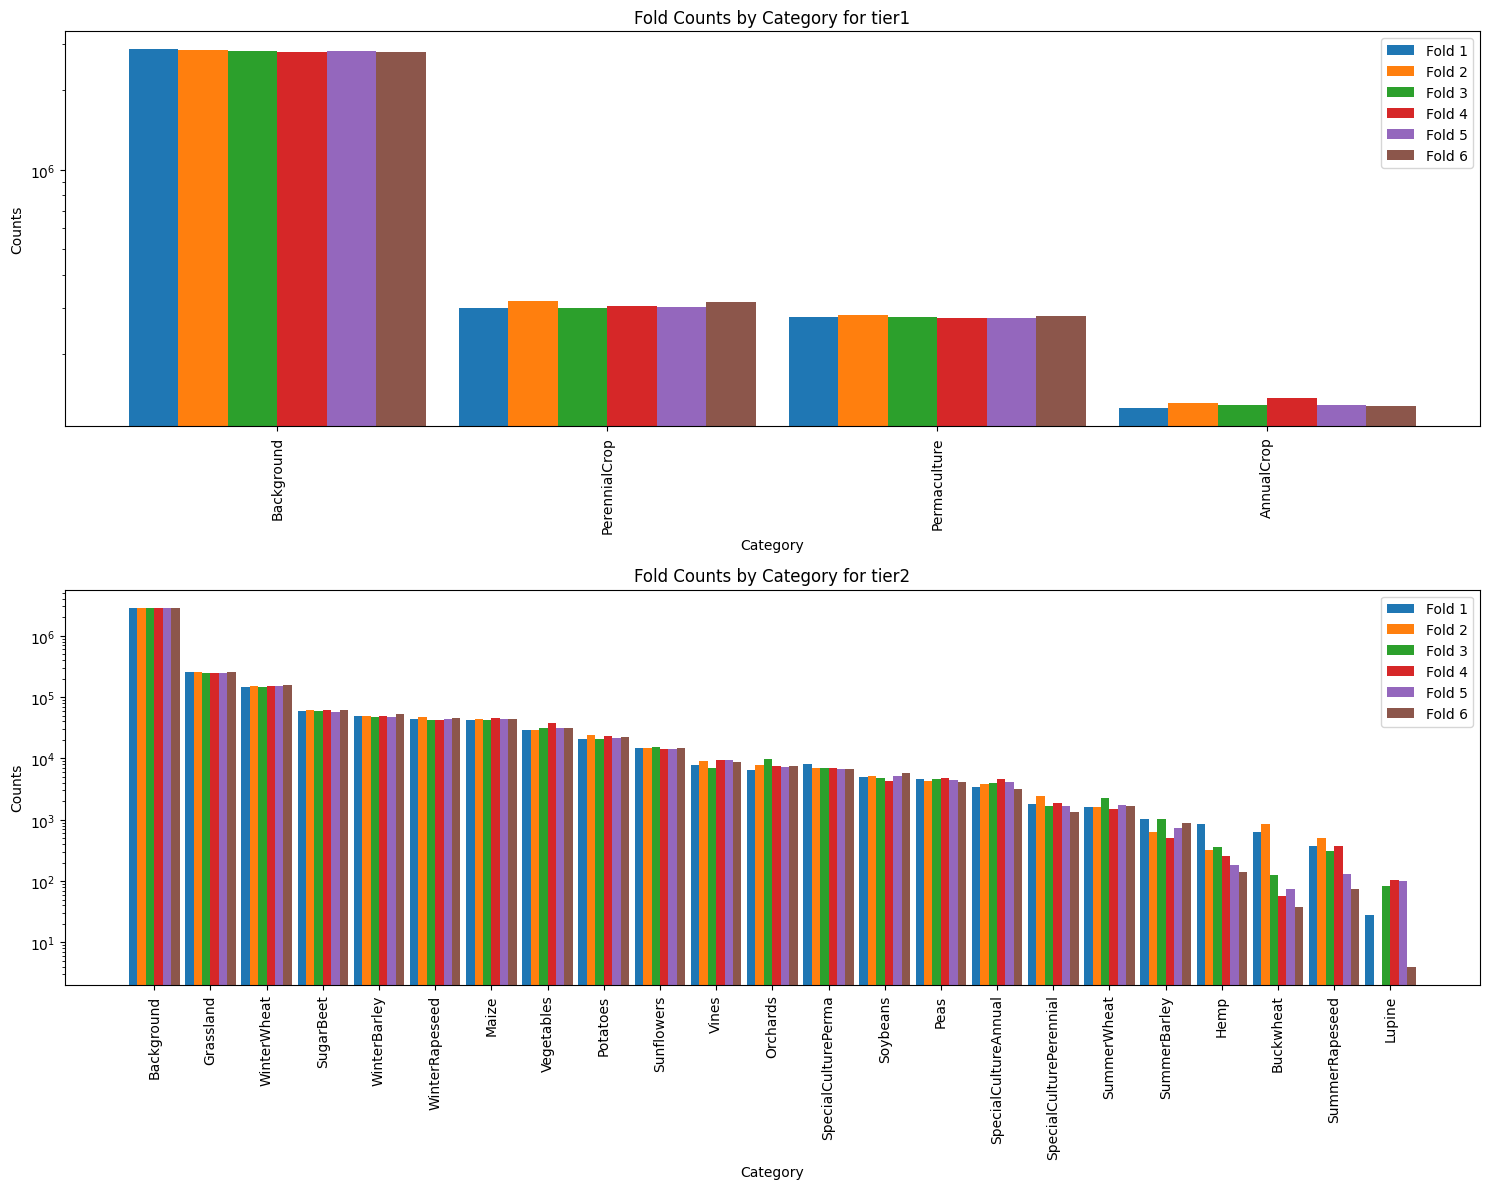

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=False)
fig.subplots_adjust(hspace=0.4)

for ax, tier in zip(axes, ["tier1", "tier2"]):
    categories = set().union(*[pixels_by_tier_category_fold[i][tier].keys() for i in range(N_FOLDS)])
    index = np.arange(len(categories))
    bar_width = 0.15
    counts_by_fold = []
    for fold in range(N_FOLDS):
        counts = [pixels_by_tier_category_fold[fold][tier].get(cat, 0) for cat in categories]
        counts_by_fold.append(counts)
    # aggregate counts by category
    counts = np.sum(counts_by_fold, axis=0)
    # order the categories and counts by counts
    categories = [cat for _, cat in sorted(zip(counts, categories), key=lambda pair: pair[0], reverse=True)]
    for fold in range(N_FOLDS):
        counts = [pixels_by_tier_category_fold[fold][tier].get(cat, 0) for cat in categories]
        ax.bar(index + fold * bar_width, counts, bar_width, label=f'Fold {fold+1}')
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'Fold Counts by Category for {tier}')
    ax.set_xticks(index + bar_width * (N_FOLDS - 1) / 2)
    labels = [dataset_info[tier][cat] for cat in categories]
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

plt.tight_layout()
plt.show()

In [25]:
tier2_to_tier1 = dataset_info["tier2_to_tier1"] # array where index is tier3 and value is tier1

In [26]:
print(tier2_to_tier1) # array where index is tier2 and value is tier1

[0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3]


In [27]:
# aggregate all folds of pixels_by_tier_category_fold
pixels_by_tier_category = {
    "tier1": {},
    "tier2": {},
    # "tier3": {}
}
for tier in pixels_by_tier_category.keys():
    for fold in range(N_FOLDS):
        for clazz, count in pixels_by_tier_category_fold[fold][tier].items():
            if clazz in pixels_by_tier_category[tier]:
                pixels_by_tier_category[tier][clazz] += count
            else:
                pixels_by_tier_category[tier][clazz] = count

pixels_by_tier_category # dict with each tier as key. The value is a dict again with the category as tier and the pixel count as value

{'tier1': {0: 16909914, 1: 773555, 2: 1831517, 3: 1659286},
 'tier2': {0: 16909914,
  2: 296026,
  5: 900795,
  9: 265802,
  10: 30330,
  18: 1519853,
  20: 46415,
  22: 42045,
  3: 261712,
  6: 358077,
  14: 26632,
  16: 191321,
  7: 132455,
  11: 87017,
  8: 1756,
  12: 22973,
  4: 10375,
  19: 50973,
  21: 10817,
  17: 1771,
  15: 320,
  1: 4810,
  13: 2083}}

In [28]:
# Prepare data for Sankey diagram
node_labels = ["Vegetation"]

# Create labels for tier 1 nodes
tier1_labels = [f"1 - {dataset_info['tier1'][i]}" for i in sorted(list(pixels_by_tier_category['tier1'].keys())) if i != 0]
node_labels.extend(tier1_labels)

# Create labels for tier 2 nodes
tier2_labels = [f"2 - {dataset_info['tier2'][i]} [{pixels_by_tier_category['tier2'][i]:,}]" for i in sorted(list(pixels_by_tier_category['tier2'].keys())) if i != 0]
node_labels.extend(tier2_labels)

# Create source and target lists based on the provided relationships
sources = []
targets = []
values = []

# Tier1 to Vegetation links
for i, t1_index in enumerate(tier1_labels):

    sources.append(0)  # Index of Vegetation node
    targets.append(i+1)  # Adjust index for tier 1 node
    values.append(pixels_by_tier_category['tier1'][i+1])

# Tier2 to Tier1 links
for i, t1_index in enumerate(tier2_to_tier1):
    if i == 0:
        continue
    targets.append(len(tier1_labels) + i)  # Adjust index for tier 2 node
    sources.append(t1_index)  # Adjust index for tier 1 node
    values.append(pixels_by_tier_category['tier2'][i])

# Create the Sankey diagram using Plotly
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ),
    arrangement='snap'
)])

fig.update_layout(title_text="<b>ZueriCrop Label Hierarchy</b> (Bands represent number of pixels in dataset)", font_size=15, height=1000)

fig.write_image("../assets/ZueriCrop_2.0_Seasonality_Tiers_Sankey.pdf", width=1200, height=1500)

fig.show()

In [29]:
# Create a DataFrame for each tier
tier1_data = pd.DataFrame({
    'tier': [f"{dataset_info['tier1'][i]}" for i in pixels_by_tier_category['tier1'].keys() if i != 0],
    'count': [pixels_by_tier_category['tier1'][i] for i in pixels_by_tier_category['tier1'].keys() if i != 0]
})

tier2_data = pd.DataFrame({
    'tier': [f"{dataset_info['tier2'][i]}" for i in pixels_by_tier_category['tier2'].keys() if i != 0],
    'count': [pixels_by_tier_category['tier2'][i] for i in pixels_by_tier_category['tier2'].keys() if i != 0]
})

tier_data_list = [tier1_data, tier2_data]

# Create a subplot for each tier category
fig = make_subplots(rows=2, cols=1, subplot_titles=['1st Tier', '2nd Tier'])

# Iterate over each tier and create a bar chart
for i, tier_data in enumerate(tier_data_list, start=1):
    grouped_data = tier_data.sort_values(by='count', ascending=False)

    # Create a color map for the current tier
    random.seed(42)
    color_map = {category: f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)' for category in grouped_data['tier'].unique()}
    bar_colors = grouped_data['tier'].map(color_map)

    fig.add_trace(
        go.Bar(
            x=grouped_data['tier'],
            y=grouped_data['count'],
            # marker_color=bar_colors
        ),
        row=i, col=1
    )

    fig.update_traces(
        hovertemplate="<b>%{x}</b><br>Count: %{y}",
        selector=dict(row=i, col=1)
    )

    fig.update_yaxes(type="log", row=i, col=1)

fig.update_layout(
    title="Number of Pixels by Tier Category",
    height=700,  # Adjust the height to accommodate all subplots
    showlegend=False
)

fig.write_image("../assets/ZueriCrop_2.0_Seasonality_Tiers_Class_Distribution.pdf", width=1200, height=700)

fig.show()

In [30]:
tier2_keys = [i for i in pixels_by_tier_category['tier2'].keys() if i != 0]
tier2_labels = [f"{dataset_info['tier2'][i]}" for i in tier2_keys]
tier2_pixels = [pixels_by_tier_category['tier2'][i] for i in tier2_keys]
tier2_to_tier1 = [dataset_info['tier2_to_tier1'][i] for i in tier2_keys]

tier2_data = pd.DataFrame({
    'tier2_label': tier2_labels,
    'count': tier2_pixels,
    'tier1_label': [dataset_info['tier1'][tier1_index] for tier1_index in tier2_to_tier1]
})
tier2_data = tier2_data.sort_values(by='count', ascending=False)

# Create a unique color for each tier1 category
random.seed(9)
color_map = {tier: f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)' for tier in tier2_data['tier1_label'].unique()}
bar_colors = tier2_data['tier1_label'].map(color_map)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=tier2_data['tier2_label'],
    y=tier2_data['count'],
    marker_color=bar_colors,
    text=[f"{count:,}" for tier2, count in zip(tier2_data['tier2_label'], tier2_data['count'])],
    showlegend=False  # Hide the bar trace from the legend
))

fig.update_traces(
    hovertemplate="<b>%{x}</b><br>Count: %{y}<br>Tier 1: %{text}"
)

legend_items = [go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color=color),
    legendgroup=tier,
    showlegend=True,
    name=tier
) for tier, color in color_map.items()]

for item in legend_items:
    fig.add_trace(item)

fig.update_layout(
    title="Number of Pixels per Tier 2 Label",
    xaxis_title="Tier 2 Label",
    yaxis_title="Number of Pixels",
    yaxis_type="log",
    height=900,
    showlegend=True,
    legend=dict(
        title="Tier 1 Labels:",
        orientation="h",  # Horizontal orientation
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

fig.write_image("../assets/ZueriCrop_2.0_Seasonality_Tier_2_Class_Distribution.pdf", width=1200, height=600)

fig.show()


In [32]:
# Count total number of pixels
total_pixels = 0
total_pixels_without_background = 0
for cls in pixels_by_tier_category['tier1']:
    total_pixels += pixels_by_tier_category['tier1'][cls]
    if cls == 0:
        continue
    total_pixels_without_background += pixels_by_tier_category['tier1'][cls]

print(f"Total Pixels: {total_pixels:,}")
print(f"Total Pixels (without background): {total_pixels_without_background:,}")

Total Pixels: 21,174,272
Total Pixels (without background): 4,264,358
